# Numerai Example Notebook

Welcome to the [Numerai](https://numer.ai/) data science tournament! If you are just getting started, this notebook is for you.

In this notebook we will go through
1. The Dataset: how to download it and understanding its basic structure
2. Modelling: how to train our first model and evaluate its performance  
3. Submissions: how to upload our first model and start competing in the tournament

In [11]:
# Install dependencies
%pip install -q numerapi pandas matplotlib lightgbm pyarrow

Note: you may need to restart the kernel to use updated packages.


## 1. The Dataset  

Let's start by downloading the dataset and getting familiar with its basic structure.


In [4]:
# NumerAPI is the official Python client for Numerai
from numerapi import NumerAPI
import pandas as pd
import json

In [5]:
# Let's start by downloading the training data and feature metadata
# This may take a few minutes 🍵
napi = NumerAPI()
napi.download_dataset("v4.1/train.parquet")
napi.download_dataset("v4.1/features.json")

2023-04-06 11:37:15,614 INFO numerapi.utils: target file already exists
2023-04-06 11:37:15,618 INFO numerapi.utils: download complete
2023-04-06 11:37:16,027 INFO numerapi.utils: target file already exists
2023-04-06 11:37:16,027 INFO numerapi.utils: download complete


In [8]:
# We want to avoid loading the entire dataset into memory
# Here we only load the a small subset of features and the target column
feature_metadata = json.load(open("v4.1/features.json")) 
features = feature_metadata["feature_sets"]["small"]
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + features + ["target"]) 

In [9]:
# Let's take a look at the first few rows of the training data
training_data.head()

,era,feature_bijou_penetrant_syringa,feature_burning_phrygian_axinomancy,feature_coraciiform_sciurine_reef,feature_corporatist_seborrheic_hopi,feature_cyclopedic_maestoso_daguerreotypist,feature_distressed_bloated_disquietude,feature_ecstatic_foundational_crinoidea,feature_elaborate_intimate_bor,feature_entopic_interpreted_subsidiary,...,feature_tragical_rainbowy_seafarer,feature_ugrian_schizocarpic_skulk,feature_undisguised_unenviable_stamen,feature_undrilled_wheezier_countermand,feature_unpainted_censual_pinacoid,feature_unreproved_cultish_glioma,feature_unsizable_ancestral_collocutor,feature_unswaddled_inenarrable_goody,feature_unventilated_sollar_bason,target
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0.00,0.00,0.50,1.00,0.50,0.50,0.00,0.50,0.50,...,0.00,0.00,1.00,0.75,1.0,1.00,0.5,0.25,0.00,0.25
n003bee128c2fcfc,0001,0.50,0.75,0.50,0.25,0.50,0.75,1.00,0.75,1.00,...,1.00,0.25,0.25,0.25,1.0,0.25,0.5,0.75,0.25,0.75
n0048ac83aff7194,0001,0.25,0.25,1.00,0.75,0.75,0.75,0.75,0.75,0.00,...,0.50,1.00,1.00,0.75,0.0,0.25,1.0,0.75,1.00,0.50
n00691bec80d3e02,0001,0.75,0.75,0.75,0.25,0.25,0.00,0.00,0.00,0.25,...,0.75,0.75,0.25,0.50,1.0,0.00,0.5,0.50,0.75,0.75
n00b8720a2fdc4f2,0001,0.00,0.00,0.00,1.00,0.25,0.25,0.75,0.25,0.00,...,0.75,0.00,1.00,0.25,1.0,0.00,0.0,1.00,0.00,0.75


At a high level
- Each row `id` represents a stock at a specific point in time `era`
- The `features` are quantitative measures of the stock known at that point in time
- The `target` is a quantitative measure of subsequent returns relative to that point in time  

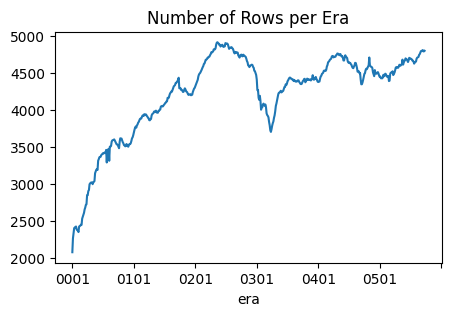

In [20]:
# The number of rows per era changes over time
# This correspondss to the number stocks in Numerai's investable universe
training_data.groupby("era").size().plot(title="Number of Rows per Era", figsize=(5, 3));

In [21]:
# Feature columns are all prefixed with "feature_"
# Feature names are randomly generated and have no special meaning
# The underlying financial concepts behind each feature is not important to understand
# Just know that the Numerai has engineered these features to be predictive of the target
features[:10]

['feature_bijou_penetrant_syringa',
 'feature_burning_phrygian_axinomancy',
 'feature_coraciiform_sciurine_reef',
 'feature_corporatist_seborrheic_hopi',
 'feature_cyclopedic_maestoso_daguerreotypist',
 'feature_distressed_bloated_disquietude',
 'feature_ecstatic_foundational_crinoidea',
 'feature_elaborate_intimate_bor',
 'feature_entopic_interpreted_subsidiary',
 'feature_esculent_erotic_epoxy']

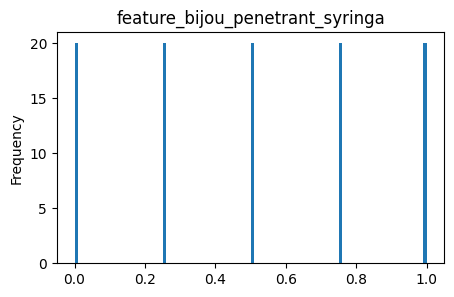

In [51]:
# Feature values are all between 0 and 1 and binned into 5 equal bins 
training_data[features[0]].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title=features[0]);

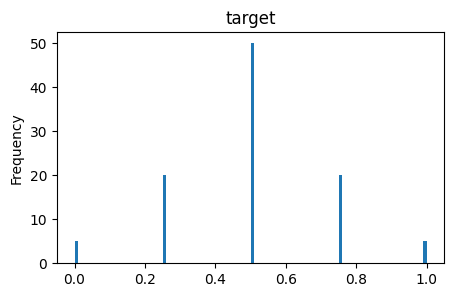

In [23]:
# The target value is also between 0 and 1 but binned into 5 unequal bins
training_data["target"].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title="target");

## 2. Modelling
Your task is to build a model on this historical dataset to predict future stock returns.

In [29]:
# Let's train a simple model using LightGBM
from lightgbm import LGBMRegressor
model = LGBMRegressor()
model.fit(
   training_data[features],
   training_data["target"]
);

In [30]:
# Let's download the validation dataset and make predictions against it to evaluate our model
napi.download_dataset("v4.1/validation.parquet")

2023-04-06 12:04:28,641 INFO numerapi.utils: starting download
v4.1/validation.parquet: 1.54GB [01:15, 20.4MB/s]                            


In [39]:
# Again we only load a subset of the features and the target column
# This time, let's also load the "data_type" column which indicates whether each row is validation or data
# We will only be needing the data_type == "validation" rows
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + features + ["target"])
validation_data = validation_data[validation_data["data_type"] == "validation"]

In [40]:
# The structure of the validation dataset is the same as the training dataset
validation_data.head()

,era,data_type,feature_bijou_penetrant_syringa,feature_burning_phrygian_axinomancy,feature_coraciiform_sciurine_reef,feature_corporatist_seborrheic_hopi,feature_cyclopedic_maestoso_daguerreotypist,feature_distressed_bloated_disquietude,feature_ecstatic_foundational_crinoidea,feature_elaborate_intimate_bor,...,feature_tragical_rainbowy_seafarer,feature_ugrian_schizocarpic_skulk,feature_undisguised_unenviable_stamen,feature_undrilled_wheezier_countermand,feature_unpainted_censual_pinacoid,feature_unreproved_cultish_glioma,feature_unsizable_ancestral_collocutor,feature_unswaddled_inenarrable_goody,feature_unventilated_sollar_bason,target
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,validation,0.25,0.25,0.5,0.50,1.00,0.00,0.0,0.00,...,0.00,0.25,0.0,0.25,0.00,1.00,0.5,0.50,0.75,0.50
n001e1318d5072ac,0575,validation,0.50,0.75,1.0,1.00,0.50,0.25,0.5,0.00,...,1.00,0.25,1.0,0.75,0.25,0.50,1.0,0.75,0.75,0.00
n002a9c5ab785cbb,0575,validation,0.25,0.50,0.0,0.25,0.50,0.25,1.0,0.00,...,0.25,0.50,0.0,0.25,0.50,0.50,0.0,0.75,0.25,0.50
n002ccf6d0e8c5ad,0575,validation,0.25,0.25,0.0,0.00,0.50,0.00,1.0,0.00,...,1.00,0.50,0.0,0.25,1.00,0.25,0.0,0.75,0.00,0.25
n0051ab821295c29,0575,validation,1.00,0.75,0.5,1.00,0.25,0.75,0.5,0.75,...,0.00,1.00,0.5,1.00,0.50,1.00,0.5,0.50,1.00,0.50


In [47]:
# Let's make predictions against the validation dataset
predictions = model.predict(validation_data[features])
predictions

array([0.48293115, 0.48943975, 0.50212273, ..., 0.50243542, 0.50406361,
       0.50362733])

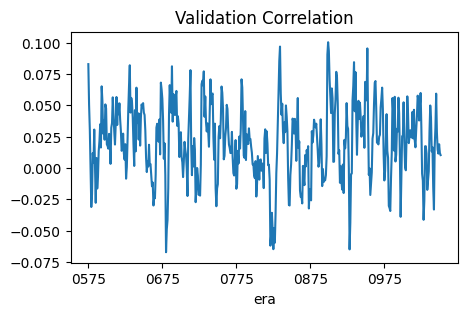

In [48]:
# How well did our model do? 
# Let's compute the per-era correlation between our predictions and the target
# Correlation to the target or CORR is the primary metric used to evaluate Numerai models
# As you can see our model has positive correlation with the target on some eras but negative correlation on others
validation_data["prediction"] = predictions
validation_data.groupby("era").apply(lambda x: x["prediction"].corr(x["target"])).plot(title="Validation Correlation", figsize=(5, 3));

In [50]:
# What is the average correlation across all eras?
# Note: predicting the stock is HARD, an average correlation of just 0.03 is considered a very good model
# Our model performance here is not great but it's good enough to get started
validation_data.groupby("era").apply(lambda x: x["prediction"].corr(x["target"])).mean()

0.0208964354611038

# 3. Submissions
Unlike a Kaggle competition where models are often evaluated based on their performance on a hold out test set, Numerai evaluates models based only on their <ins>live performance</ins> in the real stock market. This  is crucial because Numerai needs the live predictions of the tournament models to control the [Numerai Hedge Fund](numerai.fund). 

Every market day (Monday to Friday), Numerai releases a new era consisting of the latest live features. To compete in the tournament, you need to make predictions on these live features and submit them back to Numerai. 

In [52]:
# Download latest live features
napi.download_dataset("v4.1/live.parquet")

2023-04-06 12:48:31,192 INFO numerapi.utils: starting download
v4.1/live.parquet: 4.61MB [00:00, 13.6MB/s]                            


In [53]:
# Load live features
live_features = pd.read_parquet("v4.1/live.parquet", columns=features)

In [ ]:
# pickle upload etc...